"""
Project: Ant Colony Optimization with Constraints
Author: YI LUO
Date: 2025-04-08

🔗 Data Source:
https://www.kaggle.com/datasets/mexwell/large-scale-route-optimization/data

📌 Overview:
This project applies Ant Colony Optimization (ACO) to solve a real-world 
Vehicle Routing Problem (VRP) using data from a large-scale delivery network. 
We incorporate delivery constraints—such as time windows and shipment weights—
to reflect real operational priorities.

📦 What We Did:
1. Loaded distance and order datasets involving 62 cities and 4,600+ deliveries.
2. Built a city-to-city distance matrix from real geographic data.
3. Extracted metadata (urgency and weight) from delivery windows:
   - **Urgency**: computed from time between Available_Time and Deadline.
   - **Weight**: aggregated per delivery destination.
4. Implemented a modular, reusable ACO algorithm that:
   - Prioritizes urgent or heavy deliveries using constraint-aware penalties.
   - Finds the shortest route visiting all cities and returning to the depot.
5. Visualized the optimized route with:
   - Step-by-step path chart
   - Annotated network graph using urgency/weight
6. Exported the optimized delivery sequence to CSV for further analysis or deployment.

🎯 Key Result:
The ACO algorithm produced a full-city route that balances delivery cost 
(distance) with business priorities (urgency and load), demonstrating how 
metaheuristics can support real-world logistics planning.

"""


In [6]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/Users/xiexukang/VS code/Machine_Learning/ML Projects/Route Optimization'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/Users/xiexukang/VS code/Machine_Learning/ML Projects/Route Optimization/order_large.csv
/Users/xiexukang/VS code/Machine_Learning/ML Projects/Route Optimization/order_small.csv
/Users/xiexukang/VS code/Machine_Learning/ML Projects/Route Optimization/large-scale-route-optimization.ipynb
/Users/xiexukang/VS code/Machine_Learning/ML Projects/Route Optimization/information.md
/Users/xiexukang/VS code/Machine_Learning/ML Projects/Route Optimization/distance.csv
/Users/xiexukang/VS code/Machine_Learning/ML Projects/Route Optimization/Ant Colony Optimization with Constraints.ipynb


In [7]:
import numpy as np
import pandas as pd

class VRPDataLoader:
    """
    Load delivery order and distance data for VRP optimization.
    Builds a city-to-city distance matrix and indexing system.
    """
    def __init__(self, distance_file, order_file):
        self.distance_df = pd.read_csv(distance_file)
        self.order_df = pd.read_csv(order_file)
        self.cities = self._extract_cities()
        self.city_to_index = {city: i for i, city in enumerate(self.cities)}
        self.index_to_city = {i: city for city, i in self.city_to_index.items()}
        self.distance_matrix = self._build_distance_matrix()

    def _extract_cities(self):
        cities = pd.unique(self.order_df[['Source', 'Destination']].values.ravel('K'))
        return sorted(cities)

    def _build_distance_matrix(self):
        n = len(self.cities)
        matrix = np.full((n, n), np.inf)

        for _, row in self.distance_df.iterrows():
            src, dst, dist = row['Source'], row['Destination'], row['Distance(M)']
            if src in self.city_to_index and dst in self.city_to_index:
                i, j = self.city_to_index[src], self.city_to_index[dst]
                matrix[i][j] = dist
                matrix[j][i] = dist  # assume symmetric

        np.fill_diagonal(matrix, 1e6)  # avoid self-routes
        return matrix

    def preview(self):
        print("📍 Number of cities:", len(self.cities))
        print("📏 Distance matrix shape:", self.distance_matrix.shape)
        df = pd.DataFrame(self.distance_matrix, index=self.cities, columns=self.cities)
        print("🔍 Matrix preview:\n", df.iloc[:5, :5].round(0))


In [8]:
loader = VRPDataLoader(
    distance_file="/Users/xiexukang/VS code/Machine_Learning/ML Projects/Route Optimization/distance.csv",
    order_file="/Users/xiexukang/VS code/Machine_Learning/ML Projects/Route Optimization/order_large.csv"
)
loader.preview()

📍 Number of cities: 62
📏 Distance matrix shape: (62, 62)
🔍 Matrix preview:
             City_0     City_1    City_10    City_11    City_12
City_0   1000000.0    50615.0   721273.0   685050.0   922795.0
City_1     50615.0  1000000.0   700550.0   664327.0   902072.0
City_10   721273.0   700550.0  1000000.0   270054.0   263154.0
City_11   685050.0   664327.0   270054.0  1000000.0   362376.0
City_12   922795.0   902072.0   263154.0   362376.0  1000000.0


In [9]:
def build_city_metadata(order_df, city_to_index):
    """
    Build urgency and weight metadata for each city in the routing problem.

    Parameters:
        order_df: full order data with time and weight columns
        city_to_index: dict mapping city names to index

    Returns:
        metadata_df: DataFrame indexed by city index with 'Urgency' and 'Weight'
    """
    # Convert time columns to datetime
    order_df['Available_Time'] = pd.to_datetime(order_df['Available_Time'])
    order_df['Deadline'] = pd.to_datetime(order_df['Deadline'])

    # Compute urgency in hours
    order_df['Urgency'] = (order_df['Deadline'] - order_df['Available_Time']).dt.total_seconds() / 3600

    # Aggregate: take most urgent deadline and total weight per destination
    summary = order_df.groupby("Destination").agg({
        "Urgency": "min",
        "Weight": "sum"
    }).reset_index()

    # Map city name to matrix index
    summary["City_Index"] = summary["Destination"].map(city_to_index)
    summary.dropna(subset=["City_Index"], inplace=True)
    summary.set_index("City_Index", inplace=True)

    return summary[["Urgency", "Weight"]]


In [10]:
metadata = build_city_metadata(loader.order_df, loader.city_to_index)
metadata.head()


,Urgency,Weight
City_Index,,
0,36.0,362400000
1,36.0,352800000
2,60.0,527230000
3,96.0,8520000
4,60.0,1331320000


In [11]:
import numpy as np

class AntColonyOptimizer:
    def __init__(self, distance_matrix, metadata=None, num_ants=30, num_iterations=200, alpha=1.0, beta=2.0, rho=0.5):
        self.distances = distance_matrix
        self.pheromones = np.ones_like(distance_matrix)
        self.metadata = metadata
        self.num_ants = num_ants
        self.num_iterations = num_iterations
        self.alpha = alpha  # pheromone influence
        self.beta = beta    # heuristic influence
        self.rho = rho      # evaporation rate
        self.num_cities = distance_matrix.shape[0]
        self.depot = 0      # assume starting city is index 0

    def _get_penalty(self, city_idx):
        if self.metadata is None or city_idx not in self.metadata.index:
            return 1.0  # no priority
        urgency = self.metadata.loc[city_idx, 'Urgency']
        weight = self.metadata.loc[city_idx, 'Weight']
        # Higher urgency and weight → more attractive → lower penalty (inverted)
        penalty = (1.0 / (urgency + 1e-3)) + (weight / 1e7)
        return penalty

    def _calculate_probabilities(self, current_city, visited):
        allowed = [i for i in range(self.num_cities) if i not in visited and i != self.depot]
        probs = np.zeros(self.num_cities)

        for j in allowed:
            tau = self.pheromones[current_city][j] ** self.alpha
            eta = (1.0 / self.distances[current_city][j]) ** self.beta
            penalty = self._get_penalty(j)
            probs[j] = tau * eta * penalty

        total = np.sum(probs)
        return probs / total if total > 0 else np.ones(self.num_cities) / self.num_cities

    def _construct_solution(self):
        route = [self.depot]
        visited = set(route)
        total_distance = 0
        current = self.depot

        while len(visited) < self.num_cities:
            probs = self._calculate_probabilities(current, visited)
            next_city = np.random.choice(range(self.num_cities), p=probs)

            if next_city in visited:
                continue

            visited.add(next_city)
            route.append(next_city)
            total_distance += self.distances[current][next_city]
            current = next_city

        total_distance += self.distances[current][self.depot]
        route.append(self.depot)

        return route, total_distance

    def run(self):
        best_route = None
        best_distance = float('inf')

        for _ in range(self.num_iterations):
            routes = []
            distances = []

            for _ in range(self.num_ants):
                route, dist = self._construct_solution()
                routes.append(route)
                distances.append(dist)

            min_idx = np.argmin(distances)
            if distances[min_idx] < best_distance:
                best_distance = distances[min_idx]
                best_route = routes[min_idx]

            # Evaporate pheromones
            self.pheromones *= (1 - self.rho)

            # Reinforce best path
            for i in range(len(best_route) - 1):
                a, b = best_route[i], best_route[i + 1]
                self.pheromones[a][b] += 1.0 / best_distance

        return best_route, best_distance


In [12]:
import matplotlib.pyplot as plt

# Step 1: Run ACO
aco = AntColonyOptimizer(
    distance_matrix=loader.distance_matrix,
    metadata=metadata,
    num_ants=62,             # match city count for thorough search
    num_iterations=300,      # increase for better convergence
    alpha=1,
    beta=2,
    rho=0.5
)

best_indices, best_distance = aco.run()

# Step 2: Convert indices to city names
best_route = [loader.index_to_city[i] for i in best_indices]

# Step 3: Print results
print("📍 Optimized Route:")
print(" ➡ ".join(best_route))
print(f"\n📏 Total Distance: {best_distance:,.0f} meters")


📍 Optimized Route:
City_0 ➡ City_1 ➡ City_31 ➡ City_28 ➡ City_27 ➡ City_25 ➡ City_8 ➡ City_30 ➡ City_39 ➡ City_37 ➡ City_38 ➡ City_49 ➡ City_61 ➡ City_50 ➡ City_51 ➡ City_15 ➡ City_19 ➡ City_20 ➡ City_18 ➡ City_17 ➡ City_16 ➡ City_21 ➡ City_58 ➡ City_56 ➡ City_57 ➡ City_7 ➡ City_6 ➡ City_52 ➡ City_43 ➡ City_44 ➡ City_36 ➡ City_26 ➡ City_10 ➡ City_12 ➡ City_13 ➡ City_14 ➡ City_35 ➡ City_34 ➡ City_4 ➡ City_55 ➡ City_5 ➡ City_54 ➡ City_53 ➡ City_9 ➡ City_11 ➡ City_3 ➡ City_59 ➡ City_60 ➡ City_40 ➡ City_41 ➡ City_42 ➡ City_45 ➡ City_46 ➡ City_48 ➡ City_47 ➡ City_32 ➡ City_33 ➡ City_23 ➡ City_22 ➡ City_2 ➡ City_24 ➡ City_29 ➡ City_0

📏 Total Distance: 18,471,490 meters


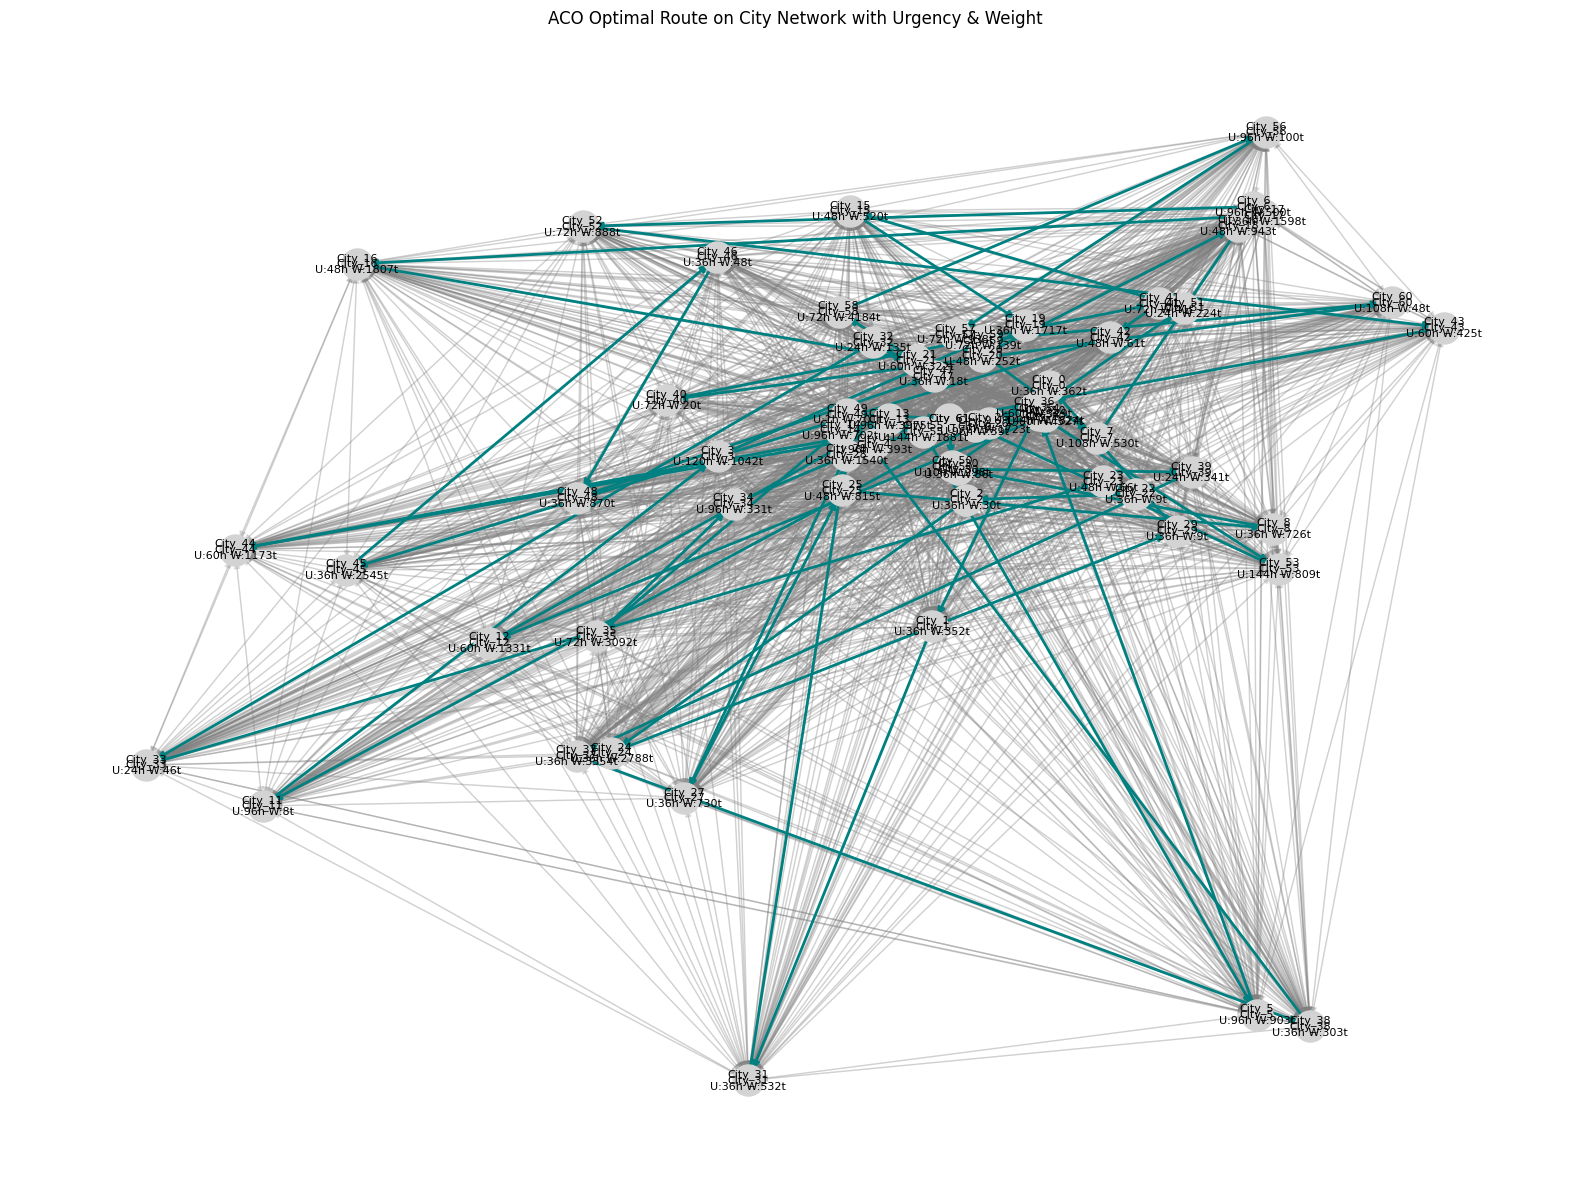

In [15]:
import networkx as nx

def draw_route_network(cities, distance_matrix, best_route, city_to_index, metadata=None):
    G = nx.DiGraph()
    G.add_nodes_from(cities)

    # Add all possible edges
    for i in range(len(cities)):
        for j in range(len(cities)):
            if i != j and distance_matrix[i][j] < np.inf:
                G.add_edge(cities[i], cities[j], weight=distance_matrix[i][j])

    # Highlight the optimal route
    route_edges = list(zip(best_route[:-1], best_route[1:]))

    plt.figure(figsize=(16, 12))
    pos = nx.spring_layout(G, seed=42)

    # Draw base graph
    nx.draw_networkx_nodes(G, pos, node_size=500, node_color='lightgray')
    nx.draw_networkx_edges(G, pos, edge_color='gray', alpha=0.2)
    nx.draw_networkx_labels(G, pos, font_size=8)

    # Draw optimal route path
    nx.draw_networkx_edges(G, pos, edgelist=route_edges, edge_color='teal', width=2)

    # Optional: add urgency/weight labels
    if metadata is not None:
        labels = {}
        for node in G.nodes:
            idx = city_to_index.get(node)
            if idx in metadata.index:
                urgency = metadata.loc[idx, 'Urgency']
                weight = metadata.loc[idx, 'Weight']
                labels[node] = f"{node}\nU:{int(urgency)}h W:{int(weight/1e6)}t"
            else:
                labels[node] = node
        nx.draw_networkx_labels(G, pos, labels=labels, font_size=8)

    plt.title("ACO Optimal Route on City Network with Urgency & Weight")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

# Draw the graph
draw_route_network(
    cities=loader.cities,
    distance_matrix=loader.distance_matrix,
    best_route=best_route,
    city_to_index=loader.city_to_index,
    metadata=metadata
)


In [17]:
def export_route_to_csv(route, filename="aco_optimized_route.csv"):
    df = pd.DataFrame({
        "Step": list(range(len(route))),
        "City": route
    })
    df.to_csv(filename, index=False)
    print(f"✅ Route exported to {filename}")

# Run export
export_route_to_csv(best_route)


✅ Route exported to aco_optimized_route.csv
